## **Planet: Understanding the Amazon from Space**

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import callbacks
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px
import seaborn as sns

import cv2
import os
from os import listdir
from tqdm import tqdm
from collections import Counter
import time
import csv

In [2]:
# Load files

base_dir = ('/kaggle/input/planets-dataset/planet/planet/')

train_dir = os.path.join(base_dir, 'train-jpg')
test_dir =  os.path.join(base_dir, 'test-jpg')
train = os.path.join(base_dir, 'train_classes.csv')
sample_submission = os.path.join(base_dir, 'sample_submission.csv')

In [3]:
# Checking the filenames of the train and test directories

print('total training images :', len(os.listdir(train_dir)))
print('total testing images :', len(os.listdir(test_dir)))

train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:5])
print(test_fnames[:5])

total training images : 40479
total testing images : 40669
['train_30370.jpg', 'train_11814.jpg', 'train_14358.jpg', 'train_18588.jpg', 'train_36435.jpg']
['test_39140.jpg', 'test_4849.jpg', 'test_18979.jpg', 'test_24790.jpg', 'test_30624.jpg']


In [4]:
# Load csv files

train = pd.read_csv(train)
train.sample(3)

,image_name,tags
10043,train_10043,cloudy
21116,train_21116,agriculture clear habitation primary road
19080,train_19080,clear primary


In [5]:
sample = pd.read_csv(sample_submission)
sample.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
import gc
gc.collect()

125

In [7]:
# Retrieve tags

tags = []

for tag_split in train.tags.to_numpy():
    labels = tag_split.split(' ')
    for label in labels:
        if label not in tags:
            tags.append(label)

Number of tags : 17


In [8]:
tags

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

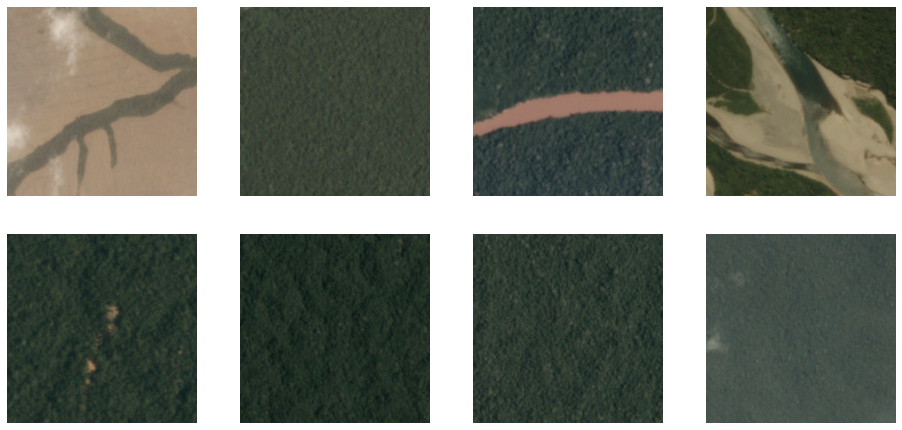

In [40]:
# Visualizing some images

nrows = 4
ncols = 4 # Images will be in a 4x4 configuration

pic_index = 2 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_pic = [os.path.join(train_dir, fname) 
                for fname in train_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_pic):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:
gc.collect()

69

Number of tags : 17
conventional_mine is tagged the least number of times : 99
primary is tagged the highest number of times : 37512


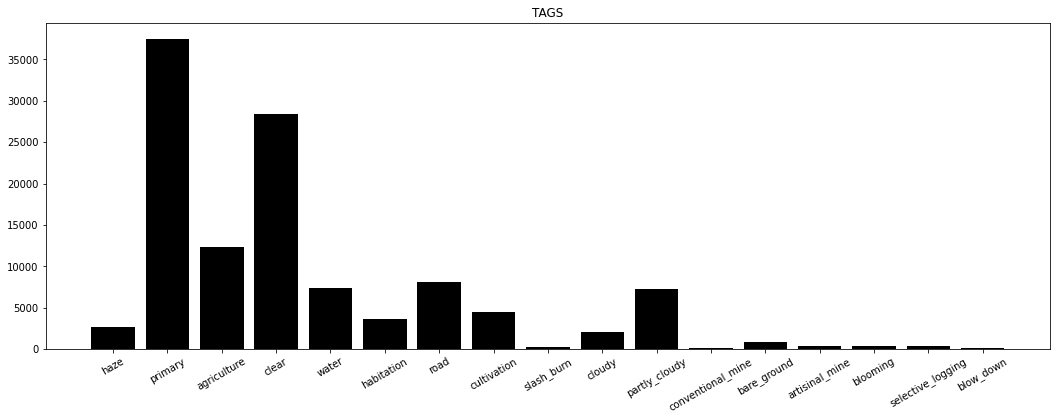

In [41]:
# Retrieve tags and visualize their distribution

tags = {}
tags_split = train['tags'].map(lambda x: x.split(' '))
for labels in tags_split.values:
    for label in labels:
        tags[label] = tags[label] + 1  if label in tags else 0

print(f'Number of tags : {len(tags)}')

min_tag = min(tags, key=tags.get)
max_tag = max(tags, key=tags.get)
print(min_tag + " is tagged the least number of times : "+str(tags[min_tag]))
print(max_tag + " is tagged the highest number of times : "+str(tags[max_tag]))

plt.figure(figsize=(18, 6))
plt.title('TAGS')
vals = range(len(tags.values()))
plt.xticks(vals, tags.keys(), rotation=30)
plt.bar(vals, tags.values(), color='black');

In [10]:
# Encode the tags

for label in tags:
    train[label] = train['tags'].apply(lambda x: 1 if label in x.split() else 0)
    
train.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Splitting data into X and y

columns = list(train.columns[2:])
train['image_name'] = train['image_name'].apply(lambda x: f'{x}.jpg')

In [12]:
import gc
gc.collect()

69

In [13]:
# Preparing the generators

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      validation_split=0.3)

validation_datagen = ImageDataGenerator(rescale = 1./255, 
                                        validation_split=0.3)

train_generator = training_datagen.flow_from_dataframe(     
    train,                            
	directory=train_dir,
    x_col='image_name',
    y_col=columns,
    subset='training',
    batch_size=64,
    class_mode='raw',
    target_size=(128, 128)
)

validation_generator = validation_datagen.flow_from_dataframe(
    train,
    directory=train_dir,
    x_col='image_name',
    y_col=columns,
    subset='validation',
    batch_size=64,
	class_mode='raw',
    target_size=(128, 128)
)

Found 28336 validated image filenames.
Found 12143 validated image filenames.


In [14]:
gc.collect()

23

In [15]:
# Modeling

model = Sequential([
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(17, activation='sigmoid')
])

model.summary()

2023-01-17 13:33:32.052340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 13:33:32.056245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 13:33:32.056995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 13:33:32.058835: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 256)     7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 256)     590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 128)       295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0

In [16]:
# F Score

def f_score(y_true, y_pred):
    
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    
    return tf.reduce_mean(f_score)

In [17]:
# A function for accuracy

def accuracy(y_true, y_pred, epsilon = 1e-4):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
        tp = tf.reduce_sum(y_true * y_pred, axis = 1)
        fp = tf.reduce_sum(y_pred, axis = 1) - tp
        fn = tf.reduce_sum(y_true, axis = 1) - tp
    
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)
        
        tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
        
        return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [18]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=[f_score, accuracy])

#Adding Callback
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=3,
    restore_best_weights=True)

In [19]:
gc.collect()

23

In [20]:
# Hyperparameters

BATCH = 64
EPOCHS = 15

history = model.fit(
    x=train_generator,
    validation_data = validation_generator,
    batch_size = BATCH,
    epochs = EPOCHS,
    callbacks= [early_stopping])

2023-01-17 13:33:35.559517: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-17 13:33:37.976196: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


443/443 [==============================] - 247s 533ms/step - loss: 0.2468 - f_score: 0.6372 - accuracy: 0.9049 - val_loss: 0.2360 - val_f_score: 0.6595 - val_accuracy: 0.9095
Epoch 2/15
443/443 [==============================] - 201s 454ms/step - loss: 0.2154 - f_score: 0.6861 - accuracy: 0.9162 - val_loss: 0.2014 - val_f_score: 0.7550 - val_accuracy: 0.9257
Epoch 3/15
443/443 [==============================] - 200s 451ms/step - loss: 0.1871 - f_score: 0.7338 - accuracy: 0.9255 - val_loss: 0.1749 - val_f_score: 0.7615 - val_accuracy: 0.9287
Epoch 4/15
443/443 [==============================] - 201s 453ms/step - loss: 0.1722 - f_score: 0.7700 - accuracy: 0.9317 - val_loss: 0.1630 - val_f_score: 0.7799 - val_accuracy: 0.9336
Epoch 5/15
443/443 [==============================] - 202s 456ms/step - loss: 0.1632 - f_score: 0.7825 - accuracy: 0.9344 - val_loss: 0.1585 - val_f_score: 0.8016 - val_accuracy: 0.9365
Epoch 6/15
443/443 [==============================] - 202s 455ms/step - loss: 0.1

In [21]:
gc.collect()

31

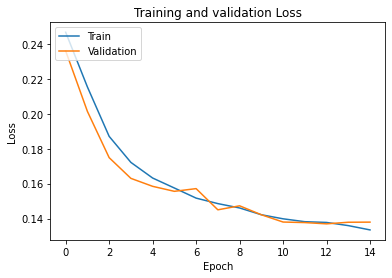

In [22]:
# Evaluate the loss of the model

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss)) # Get number of epochs

# Plot training and validation loss per epoch

plt.plot( epochs, loss )
plt.plot( epochs, val_loss )

plt.title('Training and validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show();

In [23]:
gc.collect()

3465

In [24]:
# Prepping the test set for evaluation

test = sample.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test['image_name'] = sample['image_name'].apply(lambda x: '{}.jpg'.format(x))
test.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [25]:
# Preparing the test generator

testing_datagen = ImageDataGenerator(rescale = 1./255)

testing_generator = testing_datagen.flow_from_dataframe(
    test,
    directory = test_dir,
    x_col="image_name",
    y_col=None, 
    batch_size= BATCH,
    shuffle=False,
    class_mode=None, 
    target_size=(128,128))

Found 40669 validated image filenames.


In [26]:
# Predictions

y_pred = model.predict(testing_generator, batch_size= BATCH)

In [27]:
len(y_pred)

40669

In [28]:
gc.collect()

50

In [29]:
test_names = testing_generator.filenames

Predictions = pd.DataFrame(y_pred)
Predictions = Predictions.apply(lambda x: ' '.join(np.array(tags)[x >= 0.2]), axis=1)
Predictions = pd.DataFrame({'image_name': test_names, 'tags': Predictions})
Predictions.head(5)

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary cloudy partly_cloudy


In [30]:
# Preparing the additional test set for evaluation

add_test = sample.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
add_test['image_name'] = add_test['image_name'].apply(lambda x: '{}.jpg'.format(x))
add_test.tail()

,image_name
20517,file_9995.jpg
20518,file_9996.jpg
20519,file_9997.jpg
20520,file_9998.jpg
20521,file_9999.jpg


In [31]:
add_dir= ('/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional')

add_generator = testing_datagen.flow_from_dataframe(
    add_test,
    directory= '/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional',
    x_col='image_name',
    y_col = None,
    batch_size=64,
    shuffle=False,
    class_mode=None, 
    target_size=(128, 128))

Found 20522 validated image filenames.


In [32]:
# Predictions of the additional test data

y_pred2 = model.predict(add_generator, batch_size = BATCH)

add_names = add_generator.filenames

Predictions2 = pd.DataFrame(y_pred2)
Predictions2 = Predictions2.apply(lambda x: ' '.join(np.array(tags)[x >= 0.2]), axis=1)
Predictions2 = pd.DataFrame({'image_name': add_names, 'tags': Predictions2})
Predictions2.tail()

,image_name,tags
20517,file_9995.jpg,cloudy
20518,file_9996.jpg,primary agriculture clear water road
20519,file_9997.jpg,primary clear
20520,file_9998.jpg,haze primary cloudy
20521,file_9999.jpg,primary agriculture clear water habitation road


In [33]:
gc.collect()

23

In [34]:
# Combine the two dataframes 

Result = pd.concat([Predictions, Predictions2])
Result = Result.reset_index().drop('index', axis =1)
Result

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary cloudy partly_cloudy
...,...,...
61186,file_9995.jpg,cloudy
61187,file_9996.jpg,primary agriculture clear water road
61188,file_9997.jpg,primary clear
61189,file_9998.jpg,haze primary cloudy


In [35]:
Result['image_name'] = Result['image_name'].apply(lambda x: x[:-4])
Result

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary cloudy partly_cloudy
...,...,...
61186,file_9995,cloudy
61187,file_9996,primary agriculture clear water road
61188,file_9997,primary clear
61189,file_9998,haze primary cloudy


In [37]:
# Generating a csv file for submission

Result.to_csv('Submission1.csv', index=False)